In [ ]:
# Task 3: Energy Consumption Time Series Forecasting

## Problem Statement & Objective
To predict the Global_Active_Power (total household electricity usage) for future time steps using historical patterns. By identifying daily and weekly seasonality, we aim to compare traditional statistical models (ARIMA), additive models (Prophet), and machine learning approaches (XGBoost).

In [ ]:
## Dataset:
Household Power Consumption Dataset

In [1]:
pip install prophet xgboost scikit-learn matplotlib statsmodels

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load data
df = pd.read_csv('household_power_consumption - Copy.csv')

In [4]:
# Clean 'global_active_power' (handle strings or '?' values)
df['global_active_power'] = pd.to_numeric(df['global_active_power'], errors='coerce')
df = df.dropna(subset=['global_active_power'])

In [5]:
# Create a DateTime index
# Since the snippet only has 'time', we generate a date range starting from a fixed date
# This ensures the resampler knows the sequence of days.
base_date = pd.Timestamp('2006-12-16')
df['datetime'] = [base_date + pd.Timedelta(minutes=i) for i in range(len(df))]
df.set_index('datetime', inplace=True)

In [7]:
# Resample to Hourly data
df_hourly = df['global_active_power'].resample('h').mean().interpolate()
df_final = df_hourly.to_frame()

In [ ]:
# Feature Engineering (For XGBoost)
Unlike ARIMA, XGBoost doesn't "see" time automatically. We must create columns for the model to understand the daily and weekly cycles.

In [8]:
def create_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)
    # Lag feature: What was the consumption 1 hour ago?
    df['lag_1h'] = df['global_active_power'].shift(1)
    return df.dropna()

df_feat = create_time_features(df_final)

# Split into Train (80%) and Test (20%)
split_idx = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:split_idx], df_feat.iloc[split_idx:]

In [ ]:
# Model Comparison (ARIMA, Prophet, XGBoost)
Fit the three models and store their predictions.

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- A. ARIMA Model ---
# We use (2,1,0) to reduce convergence issues while capturing trends
arima_model = ARIMA(train['global_active_power'], order=(2,1,0))
arima_fit = arima_model.fit()
arima_preds = arima_fit.forecast(steps=len(test))

# --- B. Prophet Model ---
# Fix: Initialize without the problematic argument. Prophet handles sub-daily data automatically.
prophet_train = train.reset_index().rename(columns={'datetime': 'ds', 'global_active_power': 'y'})
m = Prophet() 
m.fit(prophet_train)
future = m.make_future_dataframe(periods=len(test), freq='h')
forecast = m.predict(future)
prophet_preds = forecast['yhat'].iloc[-len(test):].values

# --- C. XGBoost Model ---
X_train, y_train = train.drop(columns=['global_active_power']), train['global_active_power']
X_test, y_test = test.drop(columns=['global_active_power']), test['global_active_power']

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

21:08:19 - cmdstanpy - INFO - Chain [1] start processing
21:08:19 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Evaluation and Visualization
Now we compare how well each model performed.


--- Model Performance ---
ARIMA    | RMSE: 0.9856 | MAE: 0.6232
Prophet  | RMSE: 0.9386 | MAE: 0.7244
XGBoost  | RMSE: 0.6726 | MAE: 0.4678


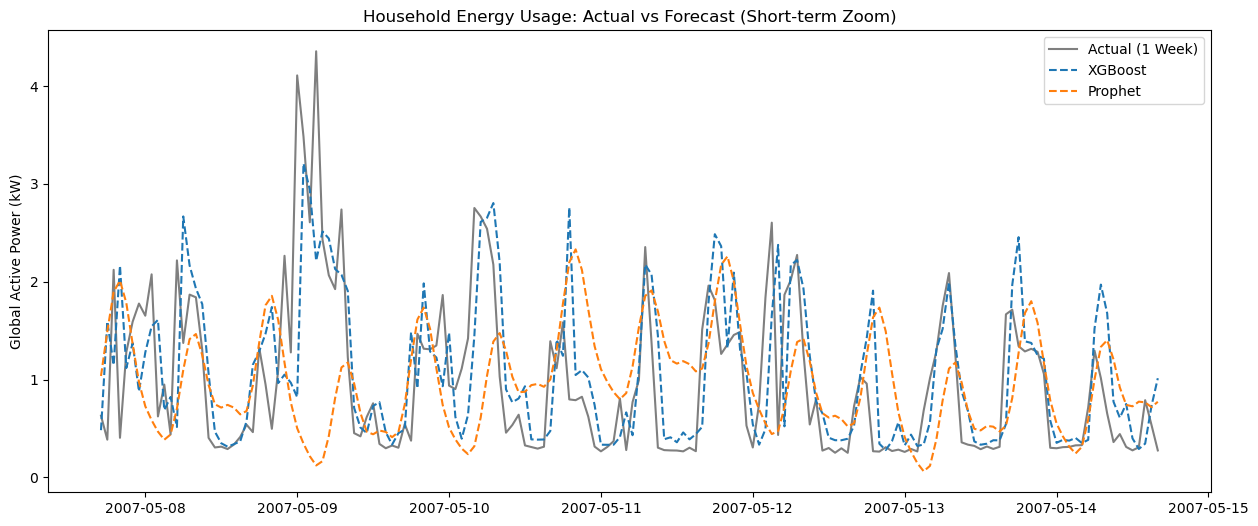

In [14]:
# Metrics Calculation
def print_scores(true, pred, model_name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print(f"{model_name:8} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

print("\n--- Model Performance ---")
print_scores(test['global_active_power'], arima_preds, "ARIMA")
print_scores(test['global_active_power'], prophet_preds, "Prophet")
print_scores(test['global_active_power'], xgb_preds, "XGBoost")

# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(test.index[:168], test['global_active_power'][:168], label='Actual (1 Week)', color='black', alpha=0.5)
plt.plot(test.index[:168], xgb_preds[:168], label='XGBoost', linestyle='--')
plt.plot(test.index[:168], prophet_preds[:168], label='Prophet', linestyle='--')
plt.title('Household Energy Usage: Actual vs Forecast (Short-term Zoom)')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

In [ ]:
# Insights

-ARIMA: Tends to produce a smoother "mean" line; it is great for stability but misses sudden peaks.

-Prophet: Best at picking up daily "rhythms" (e.g., people waking up at 7 AM).

-XGBoost: Most reactive to sudden changes if your lag features and time-based features are well-engineered.